In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pysam import VariantFile
from scipy.stats import binomtest

In [2]:
vcf_path = 'data/HG00171/processed/spliceai-out.vcf'
true_p_acceptor_path = 'data/HG00171/processed/p_acceptor.csv'
true_p_donor_path = 'data/HG00171/processed/p_donor.csv'

In [3]:
# load & prepare predicted data

vcf = VariantFile(vcf_path, 'r')
# we use vanilla dicts because index-lookups are less
# computationally complex than in pandas dataframes
p_acceptor = dict()
p_donor = dict()
def _set_or_add(d, k, v):
    if k in d: d[k] += [v, 1]
    else: d[k] = np.array([v, 1])

for record in vcf:
    items = dict(record.info.items())
    if 'SpliceAI' not in items: continue
    results = items['SpliceAI']
    for result in results:
        fields = result.split('|')
        pos_ag, pos_al, pos_dg, pos_dl = (record.pos + int(p) for p in fields[6:10])
        ag, al, dg, dl = (float(val) for val in [fields[11], fields[13], fields[15], fields[17]])
        _set_or_add(p_acceptor, pos_ag, ag)
        _set_or_add(p_acceptor, pos_al, al)
        _set_or_add(p_donor, pos_dg, dg)
        _set_or_add(p_donor, pos_dl, dl)

# apply means
for k, v in p_acceptor.items(): p_acceptor[k] = v[0] / v[1]
for k, v in p_donor.items(): p_donor[k] = v[0] / v[1]
# create dataframes
p_acceptor = pd.DataFrame(p_acceptor.items(), columns=['5p', 'p']).set_index('5p')
p_donor = pd.DataFrame(p_donor.items(), columns=['3p', 'p']).set_index('3p')

In [4]:
# load experimental "true" data

def _get_experimental_data(path):
    df = pd.read_csv(path, index_col=0)
    df['k'] = (df['p'] * df['n']).astype(int)
    return df.to_dict('index')

true_p_acceptor = _get_experimental_data(true_p_acceptor_path)
true_p_donor = _get_experimental_data(true_p_donor_path)

In [5]:
def analyze_results(predictions, experimental_data, cutoff = 0.1):
    def _pvalue(row):
        site = row.name
        pred = row.iloc[0]
        if site not in experimental_data:
            return np.NaN
        experiment = experimental_data[site]
        return binomtest(experiment['k'], experiment['n'], p=pred).pvalue
    # binomial test p-values
    pvalues = predictions.apply(_pvalue, axis=1)
    # number of observed sites that aren't predicted at all
    observed_unpredicted = len(set(experimental_data.keys()) - set(predictions.index))
    # number of predicted sites that weren't observed
    predicted_unobserved = sum((np.isnan(pvalues)) & (predictions['p'] > cutoff))
    return (
        pvalues,
        np.array([observed_unpredicted, len(experimental_data)]),
        np.array([predicted_unobserved, sum(predictions['p'] > cutoff)])
    )

Number of unpredicted observed splice sites: 12158 (42% of observed sites)
Number of predicted unobserved splice sites: 6059 (27% of predicted sites)
Number of pvalues < 0.001: 10249 (62% of predicted sites)
Number of pvalues on plot: 6378 (38% of predicted sites)


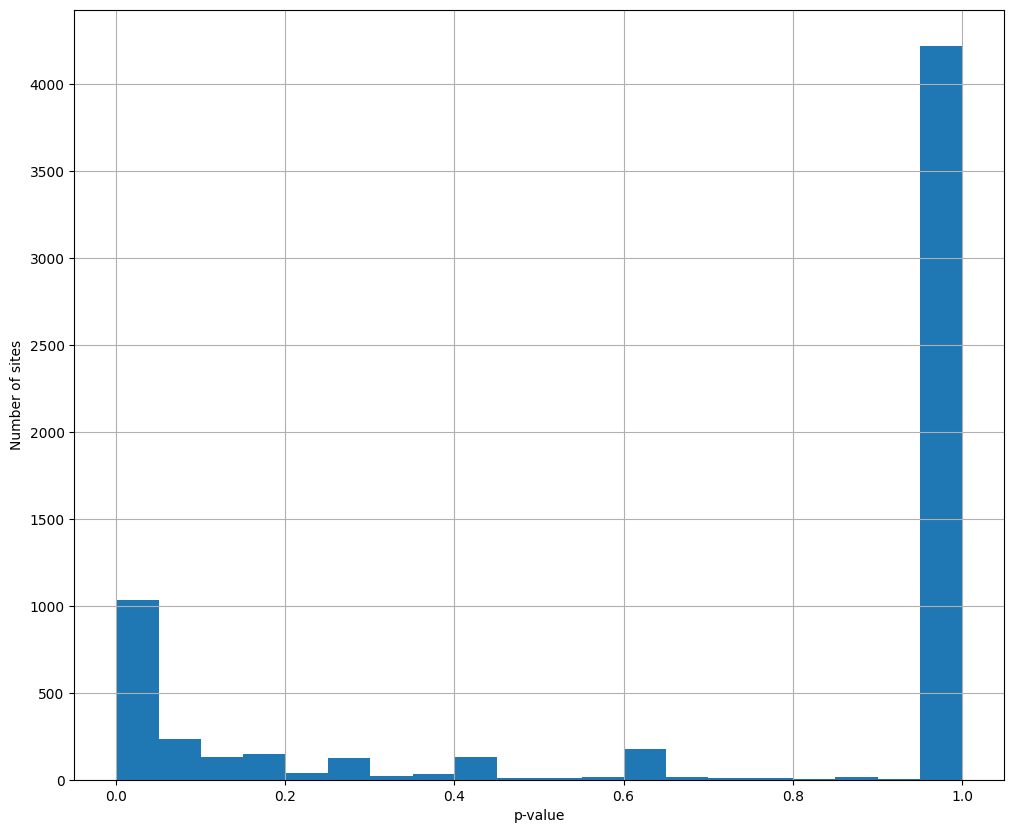

In [6]:
pvalues = list()
observed_unpredicted = np.array([0, 0])
predicted_unobserved = np.array([0, 0])

for site, predictions, experiments in [('Acceptor', p_acceptor, true_p_acceptor), ('Donor', p_donor, true_p_donor)]:
    p, ou, pu = analyze_results(predictions, experiments)
    pvalues += list(p)
    observed_unpredicted += ou
    predicted_unobserved += pu

print(f'Number of unpredicted observed splice sites: {observed_unpredicted[0]} ({float(observed_unpredicted[0]) / observed_unpredicted[1] * 100 :.0f}% of observed sites)')
print(f'Number of predicted unobserved splice sites: {predicted_unobserved[0]} ({float(predicted_unobserved[0]) / predicted_unobserved[1] * 100 :.0f}% of predicted sites)')
pvalues = pd.Series(pvalues)
cutoff = 0.001
very_bad = sum(pvalues < cutoff)
not_very_bad = sum(pvalues >= cutoff)
total = sum(~np.isnan(pvalues))
print(f'Number of pvalues < {cutoff}: {very_bad} ({float(very_bad) / total * 100 :.0f}% of predicted sites)')
print(f'Number of pvalues on plot: {not_very_bad} ({float(not_very_bad) / total * 100 :.0f}% of predicted sites)')
pvalues[pvalues > cutoff].hist(bins=20, figsize=(12,10))
plt.xlabel ('p-value')
plt.ylabel ('Number of sites')
plt.savefig('figures/plot.png', bbox_inches='tight')
plt.show()